In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob, os

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

NumPy version: 2.3.5
Pandas version: 2.3.3


In [2]:
# Point to one .set file (MNE will automatically read the .fdt file)
set_file = "/home/abin/ds003478-download/sub-001/eeg/sub-001_task-Rest_run-01_eeg.set"

raw = mne.io.read_raw_eeglab(set_file, preload=True)
raw

Reading /home/abin/ds003478-download/sub-001/eeg/sub-001_task-Rest_run-01_eeg.fdt
Reading 0 ... 250733  =      0.000 ...   501.466 secs...


<RawEEGLAB | sub-001_task-Rest_run-01_eeg.fdt, 66 x 250734 (501.5 s), ~126.3 MiB, data loaded>

In [12]:
print("Channels:", raw.info["nchan"])
print("Sampling rate:", raw.info["sfreq"])
print("Duration (sec):", raw.n_times / raw.info["sfreq"])
print("Channel names:", raw.ch_names[:20])  # show first 20

Channels: 66
Sampling rate: 500.0
Duration (sec): 501.468
Channel names: ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2']


In [ ]:
# raw._data is numpy array: shape = (channels, samples)
data = raw.get_data()

print("Data shape:", data.shape)   # (66, ~250k samples)
print("First 10 values of channel 0:")
print(data[0, :10])


Data shape: (66, 250734)
First 10 values of channel 0:
[0.00026751 0.00027322 0.00027616 0.00028821 0.00030779 0.00032191
 0.00032284 0.00031604 0.00031393 0.00032305]


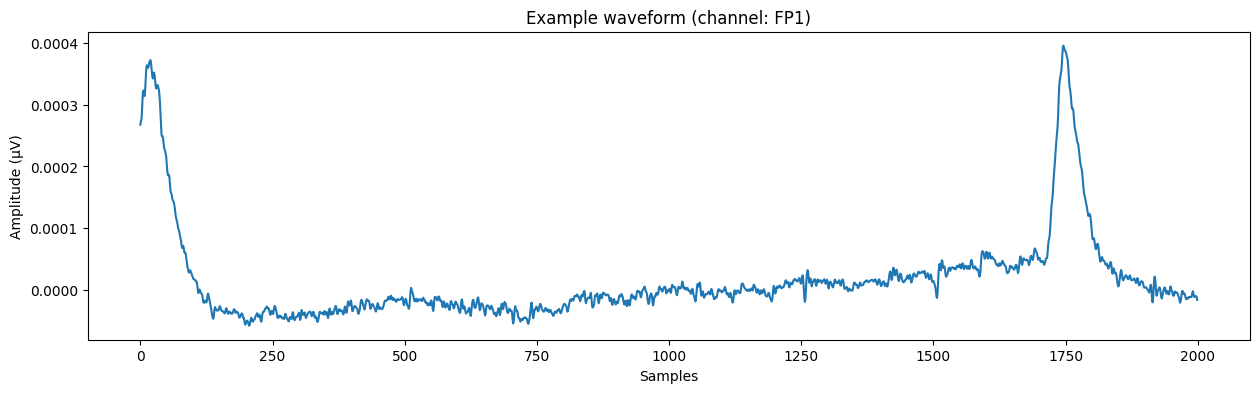

In [7]:
plt.figure(figsize=(15, 4))
plt.plot(data[0, :2000])  # first 2000 samples of channel 0
plt.title(f"Example waveform (channel: {raw.ch_names[0]})")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.show()

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_7748/4108630121.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/home/abin/eeg-mlflow/.venv/lib/python3.11/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


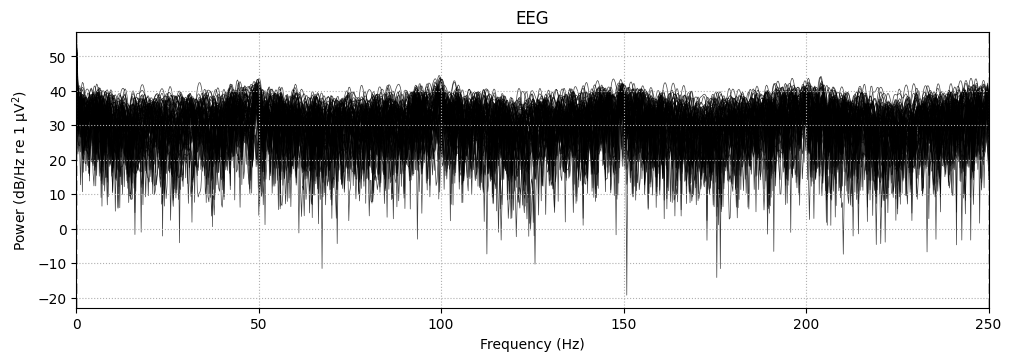

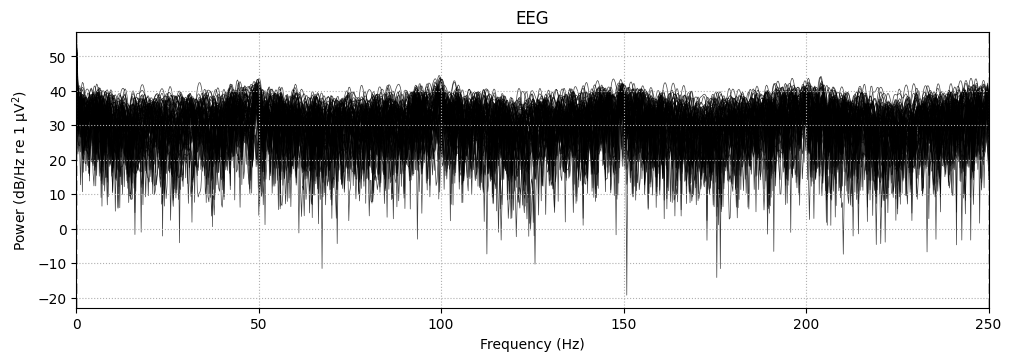

In [12]:
raw.compute_psd().plot()

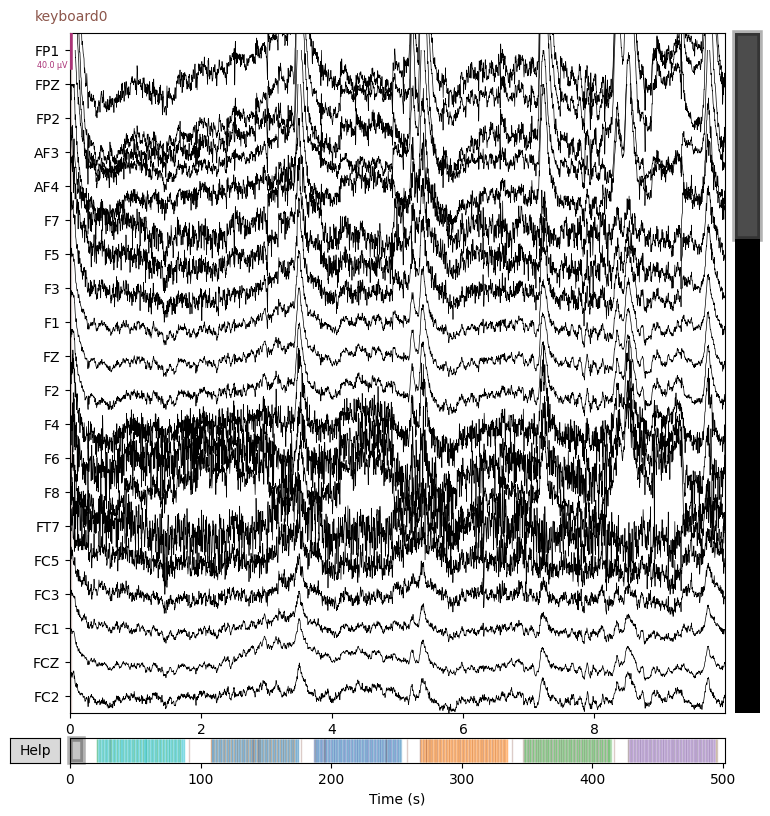

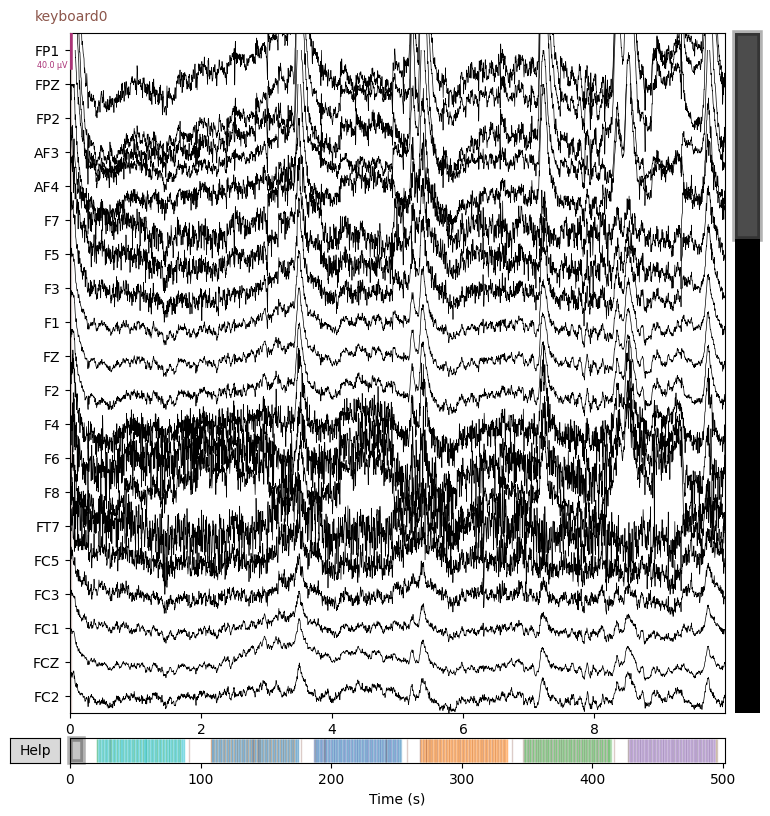

In [13]:
raw.plot()

In [9]:
# Compute PSD vectors per channel and assemble into a DataFrame
sfreq = float(raw.info["sfreq"])  # sampling frequency
fmin, fmax = 0.5, min(50.0, sfreq / 2.0)  # editable frequency range (Hz)

# Use MNE's Welch method to compute PSD
spectrum = raw.compute_psd(method="welch", fmin=fmin, fmax=fmax)
psd_array, freqs = spectrum.get_data(return_freqs=True)

# Ensure shape is (n_channels, n_freqs)
if psd_array.ndim == 3:
    # e.g., (n_segments, n_channels, n_freqs) -> average segments
    psd_array = psd_array.mean(axis=0)

channel_names = raw.ch_names

# Wide DataFrame: rows = channels, columns = frequency bins
import pandas as pd
_df = pd.DataFrame(psd_array, index=channel_names, columns=freqs)
_df.index.name = "channel"
_df.columns = [f"{f:.2f}Hz" for f in _df.columns]

df_psd = _df  # final PSD table

# Also provide a mapping: channel -> PSD vector (numpy array)
channel_to_psd_vector = {ch: psd_array[i] for i, ch in enumerate(channel_names)}

print("PSD shape (channels x freqs):", psd_array.shape)
df_psd.head()


Effective window size : 4.096 (s)
PSD shape (channels x freqs): (66, 202)


,0.73Hz,0.98Hz,1.22Hz,1.46Hz,1.71Hz,1.95Hz,2.20Hz,2.44Hz,2.69Hz,2.93Hz,...,47.61Hz,47.85Hz,48.10Hz,48.34Hz,48.58Hz,48.83Hz,49.07Hz,49.32Hz,49.56Hz,49.80Hz
channel,,,,,,,,,,,,,,,,,,,,,
FP1,3.695717e-07,2.894082e-07,2.510958e-07,2.540576e-07,1.293137e-07,1.644157e-07,3.093615e-07,2.567766e-07,1.643997e-07,2.697654e-07,...,1.513718e-07,2.783873e-07,4.902756e-07,5.201220e-07,3.623746e-07,3.000755e-07,3.729462e-07,3.364868e-07,2.711641e-07,1.935147e-07
FPZ,2.140174e-07,1.501885e-07,1.321501e-07,1.122960e-07,5.868873e-08,1.139651e-07,4.124109e-07,5.223516e-07,1.960059e-07,1.352817e-07,...,1.634715e-07,2.112510e-07,5.296302e-07,4.575758e-07,1.908440e-07,8.256298e-08,8.266455e-08,1.024339e-07,1.309766e-07,1.054153e-07
FP2,5.247050e-08,5.349503e-08,8.376468e-08,2.468289e-07,2.201378e-07,2.504492e-07,2.574938e-07,8.067924e-08,3.456607e-07,5.490720e-07,...,1.501258e-07,5.822472e-08,3.951429e-07,5.980926e-07,5.061443e-07,3.860622e-07,3.107024e-07,2.175974e-07,1.928425e-07,1.963013e-07
AF3,2.861764e-07,2.500707e-07,3.123911e-07,3.183716e-07,1.740372e-07,1.092753e-07,1.837914e-07,2.574903e-07,2.271747e-07,3.251192e-07,...,4.444229e-07,1.025342e-07,2.088229e-07,4.811959e-07,6.740816e-07,7.163364e-07,7.325461e-07,6.066600e-07,2.620533e-07,4.670780e-08
AF4,1.949316e-07,1.153668e-07,1.733692e-07,2.457373e-07,1.738130e-07,1.932365e-07,2.860345e-07,1.914180e-07,9.138254e-08,2.671062e-07,...,1.658248e-07,8.462123e-08,4.887068e-07,5.781088e-07,4.901379e-07,3.310018e-07,2.610325e-07,2.161326e-07,1.286830e-07,7.866471e-08
